# 1. 라이브러리 및 데이터

In [20]:
import warnings
import os
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [21]:
# 재생산성을 위해 시드 고정 - 7
np.random.seed(7)
random.seed(7)
tf.random.set_random_seed(7)

밝기 온도 채널만 사용하기 위해 0~8채널만 불러오기

약 7만장의 전체 데이터를 사용하지 않고, 50개 이상의 픽셀에 강수량이 기록되어 있는 이미지만 사용하기

In [22]:
def trainGenerator():
    
    train_path = 'train'
    train_files = sorted(glob.glob(train_path + '/*'))
    
    for file in train_files:
        
        dataset = np.load(file)
        
        target= dataset[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = dataset[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 1:
            
            continue

        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([40,40,9]),tf.TensorShape([40,40,1])))

In [23]:
train_dataset = train_dataset.batch(512).prefetch(1)

In [24]:
test_path = 'test'
test_files = sorted(glob.glob(test_path + '/*'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data[:,:,:9])
X_test = np.array(X_test)

test: 100%|██████████| 2416/2416 [00:02<00:00, 927.08it/s]


# 2. 데이터 전처리

## Data Cleansing & Pre-Processing

데이터 불러올 시 전처리 로직 적용

강수량에 결측값은 0으로 일괄 대체

# 3. 탐색적 자료 분석
## Exploratory Data Analysis

In [25]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [26]:
image_sample = np.load('train/subset_010462_02.npy')

밝기 온도와 강수량과의 관계 확인하기

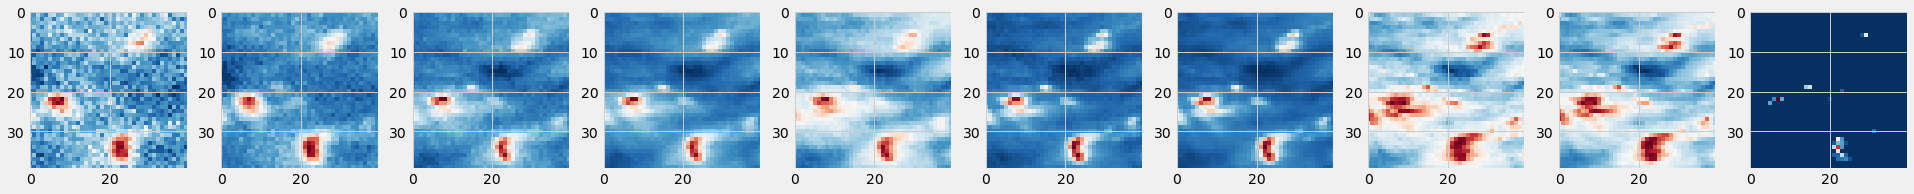

In [27]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30,30))

for i in range(9):
    plt.subplot(1,10,i+1)
    plt.imshow(image_sample[:,:,i], cmap=color_map)
    
plt.subplot(1,10,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

# 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling

모델 구축

참고한 코드 [링크1](https://www.kaggle.com/kmader/baseline-u-net-model-part-1) , [링크2](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification)

In [28]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [29]:
model = Model(input_layer, output_layer)

In [30]:
def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [31]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

# 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [32]:
model_history = model.fit(train_dataset, epochs = 20, verbose=1)

Epoch 1/20


    100/Unknown - 12s 12s/step - loss: 0.6598 - maeOverFscore_keras: 18.1026 - fscore_keras: 0.097 - 20s 10s/step - loss: 0.5948 - maeOverFscore_keras: 14.5889 - fscore_keras: 0.110 - 27s 9s/step - loss: 0.5548 - maeOverFscore_keras: 13.3775 - fscore_keras: 0.115 - 34s 8s/step - loss: 0.5264 - maeOverFscore_keras: 12.9997 - fscore_keras: 0.11 - 42s 8s/step - loss: 0.4996 - maeOverFscore_keras: 12.6010 - fscore_keras: 0.11 - 49s 8s/step - loss: 0.4745 - maeOverFscore_keras: 12.2266 - fscore_keras: 0.11 - 57s 8s/step - loss: 0.4553 - maeOverFscore_keras: 12.2494 - fscore_keras: 0.11 - 65s 8s/step - loss: 0.4393 - maeOverFscore_keras: 12.3533 - fscore_keras: 0.11 - 72s 8s/step - loss: 0.4226 - maeOverFscore_keras: 12.7553 - fscore_keras: 0.11 - 79s 8s/step - loss: 0.4094 - maeOverFscore_keras: 12.8645 - fscore_keras: 0.11 - 87s 8s/step - loss: 0.4006 - maeOverFscore_keras: 12.9291 - fscore_keras: 0.11 - 94s 8s/step - loss: 0.3902 - maeOverFscore_keras: 13.1363 - fscore_keras: 0.11 - 101s 

121/121 [==============================].2223 - maeOverFscore_keras: 7.5409 - fscore_keras: 0.31 - 753s 7s/step - loss: 0.2227 - maeOverFscore_keras: 7.5091 - fscore_keras: 0.31 - 760s 7s/step - loss: 0.2229 - maeOverFscore_keras: 7.4729 - fscore_keras: 0.31 - 767s 7s/step - loss: 0.2230 - maeOverFscore_keras: 7.4354 - fscore_keras: 0.32 - 774s 7s/step - loss: 0.2228 - maeOverFscore_keras: 7.3956 - fscore_keras: 0.32 - 782s 7s/step - loss: 0.2232 - maeOverFscore_keras: 7.3617 - fscore_keras: 0.32 - 788s 7s/step - loss: 0.2234 - maeOverFscore_keras: 7.3384 - fscore_keras: 0.32 - 796s 7s/step - loss: 0.2233 - maeOverFscore_keras: 7.3049 - fscore_keras: 0.33 - 803s 7s/step - loss: 0.2229 - maeOverFscore_keras: 7.2754 - fscore_keras: 0.33 - 809s 7s/step - loss: 0.2223 - maeOverFscore_keras: 7.2420 - fscore_keras: 0.33 - 816s 7s/step - loss: 0.2217 - maeOverFscore_keras: 7.2117 - fscore_keras: 0.33 - 823s 7s/step - loss: 0.2207 - maeOverFscore_keras: 7.1798 - fscore_keras: 0.33 - 830s 7s/st

104/121 [========================>.....] - ETA: 17:41 - loss: 0.0932 - maeOverFscore_keras: 3.9680 - fscore_keras: 0.379 - ETA: 15:59 - loss: 0.0925 - maeOverFscore_keras: 3.6496 - fscore_keras: 0.374 - ETA: 14:32 - loss: 0.0950 - maeOverFscore_keras: 3.7646 - fscore_keras: 0.360 - ETA: 14:19 - loss: 0.0957 - maeOverFscore_keras: 3.6501 - fscore_keras: 0.370 - ETA: 14:05 - loss: 0.0937 - maeOverFscore_keras: 3.4831 - fscore_keras: 0.380 - ETA: 13:39 - loss: 0.0902 - maeOverFscore_keras: 3.4801 - fscore_keras: 0.370 - ETA: 13:31 - loss: 0.0886 - maeOverFscore_keras: 3.3734 - fscore_keras: 0.379 - ETA: 13:17 - loss: 0.0888 - maeOverFscore_keras: 3.2726 - fscore_keras: 0.396 - ETA: 13:02 - loss: 0.0876 - maeOverFscore_keras: 3.2571 - fscore_keras: 0.402 - ETA: 12:51 - loss: 0.0894 - maeOverFscore_keras: 3.2635 - fscore_keras: 0.408 - ETA: 12:48 - loss: 0.0944 - maeOverFscore_keras: 3.3813 - fscore_keras: 0.407 - ETA: 12:43 - loss: 0.0962 - maeOverFscore_keras: 3.3877 - fscore_keras: 0.413

121/121 [==============================] - ETA: 1:56 - loss: 0.1516 - maeOverFscore_keras: 3.3957 - fscore_keras: 0.50 - ETA: 1:48 - loss: 0.1525 - maeOverFscore_keras: 3.3987 - fscore_keras: 0.50 - ETA: 1:41 - loss: 0.1533 - maeOverFscore_keras: 3.4073 - fscore_keras: 0.50 - ETA: 1:34 - loss: 0.1537 - maeOverFscore_keras: 3.4074 - fscore_keras: 0.51 - ETA: 1:26 - loss: 0.1539 - maeOverFscore_keras: 3.4066 - fscore_keras: 0.51 - ETA: 1:19 - loss: 0.1539 - maeOverFscore_keras: 3.4011 - fscore_keras: 0.51 - ETA: 1:12 - loss: 0.1538 - maeOverFscore_keras: 3.4004 - fscore_keras: 0.51 - ETA: 1:05 - loss: 0.1533 - maeOverFscore_keras: 3.4022 - fscore_keras: 0.51 - ETA: 58s - loss: 0.1532 - maeOverFscore_keras: 3.4087 - fscore_keras: 0.5103 - ETA: 50s - loss: 0.1531 - maeOverFscore_keras: 3.4233 - fscore_keras: 0.509 - ETA: 43s - loss: 0.1526 - maeOverFscore_keras: 3.4333 - fscore_keras: 0.508 - ETA: 36s - loss: 0.1524 - maeOverFscore_keras: 3.4323 - fscore_keras: 0.507 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 18:33 - loss: 0.0889 - maeOverFscore_keras: 3.4150 - fscore_keras: 0.431 - ETA: 16:25 - loss: 0.0882 - maeOverFscore_keras: 3.2361 - fscore_keras: 0.413 - ETA: 15:31 - loss: 0.0908 - maeOverFscore_keras: 3.5122 - fscore_keras: 0.383 - ETA: 15:08 - loss: 0.0919 - maeOverFscore_keras: 3.4992 - fscore_keras: 0.383 - ETA: 15:20 - loss: 0.0896 - maeOverFscore_keras: 3.3071 - fscore_keras: 0.397 - ETA: 15:06 - loss: 0.0859 - maeOverFscore_keras: 3.2418 - fscore_keras: 0.391 - ETA: 14:50 - loss: 0.0843 - maeOverFscore_keras: 3.1076 - fscore_keras: 0.406 - ETA: 14:34 - loss: 0.0844 - maeOverFscore_keras: 3.0039 - fscore_keras: 0.425 - ETA: 14:20 - loss: 0.0831 - maeOverFscore_keras: 2.9623 - fscore_keras: 0.435 - ETA: 14:05 - loss: 0.0848 - maeOverFscore_keras: 2.9567 - fscore_keras: 0.443 - ETA: 13:55 - loss: 0.0896 - maeOverFscore_keras: 3.0413 - fscore_keras: 0.444 - ETA: 13:46 - loss: 0.0911 - maeOverFscore_keras: 3.0359 - fscore_keras: 0.452

121/121 [==============================] - ETA: 1:58 - loss: 0.1476 - maeOverFscore_keras: 3.1493 - fscore_keras: 0.53 - ETA: 1:50 - loss: 0.1485 - maeOverFscore_keras: 3.1532 - fscore_keras: 0.53 - ETA: 1:43 - loss: 0.1493 - maeOverFscore_keras: 3.1615 - fscore_keras: 0.53 - ETA: 1:36 - loss: 0.1497 - maeOverFscore_keras: 3.1605 - fscore_keras: 0.53 - ETA: 1:28 - loss: 0.1499 - maeOverFscore_keras: 3.1602 - fscore_keras: 0.54 - ETA: 1:21 - loss: 0.1499 - maeOverFscore_keras: 3.1571 - fscore_keras: 0.54 - ETA: 1:13 - loss: 0.1499 - maeOverFscore_keras: 3.1572 - fscore_keras: 0.54 - ETA: 1:06 - loss: 0.1494 - maeOverFscore_keras: 3.1545 - fscore_keras: 0.54 - ETA: 59s - loss: 0.1492 - maeOverFscore_keras: 3.1521 - fscore_keras: 0.5402 - ETA: 51s - loss: 0.1491 - maeOverFscore_keras: 3.1559 - fscore_keras: 0.539 - ETA: 44s - loss: 0.1487 - maeOverFscore_keras: 3.1617 - fscore_keras: 0.539 - ETA: 36s - loss: 0.1485 - maeOverFscore_keras: 3.1601 - fscore_keras: 0.539 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:39 - loss: 0.0883 - maeOverFscore_keras: 3.2938 - fscore_keras: 0.442 - ETA: 15:56 - loss: 0.0874 - maeOverFscore_keras: 2.9921 - fscore_keras: 0.441 - ETA: 15:18 - loss: 0.0903 - maeOverFscore_keras: 3.1566 - fscore_keras: 0.418 - ETA: 14:52 - loss: 0.0907 - maeOverFscore_keras: 3.0595 - fscore_keras: 0.428 - ETA: 14:34 - loss: 0.0887 - maeOverFscore_keras: 2.9395 - fscore_keras: 0.437 - ETA: 14:19 - loss: 0.0850 - maeOverFscore_keras: 2.9486 - fscore_keras: 0.424 - ETA: 14:06 - loss: 0.0834 - maeOverFscore_keras: 2.8856 - fscore_keras: 0.429 - ETA: 13:52 - loss: 0.0834 - maeOverFscore_keras: 2.8190 - fscore_keras: 0.443 - ETA: 13:43 - loss: 0.0820 - maeOverFscore_keras: 2.7884 - fscore_keras: 0.453 - ETA: 13:34 - loss: 0.0839 - maeOverFscore_keras: 2.7825 - fscore_keras: 0.462 - ETA: 13:24 - loss: 0.0886 - maeOverFscore_keras: 2.8685 - fscore_keras: 0.463 - ETA: 13:16 - loss: 0.0902 - maeOverFscore_keras: 2.8818 - fscore_keras: 0.469

121/121 [==============================] - ETA: 1:57 - loss: 0.1447 - maeOverFscore_keras: 2.9442 - fscore_keras: 0.56 - ETA: 1:49 - loss: 0.1455 - maeOverFscore_keras: 2.9460 - fscore_keras: 0.56 - ETA: 1:42 - loss: 0.1463 - maeOverFscore_keras: 2.9536 - fscore_keras: 0.56 - ETA: 1:35 - loss: 0.1467 - maeOverFscore_keras: 2.9541 - fscore_keras: 0.56 - ETA: 1:27 - loss: 0.1469 - maeOverFscore_keras: 2.9545 - fscore_keras: 0.56 - ETA: 1:20 - loss: 0.1469 - maeOverFscore_keras: 2.9505 - fscore_keras: 0.56 - ETA: 1:13 - loss: 0.1469 - maeOverFscore_keras: 2.9501 - fscore_keras: 0.56 - ETA: 1:05 - loss: 0.1464 - maeOverFscore_keras: 2.9507 - fscore_keras: 0.56 - ETA: 58s - loss: 0.1463 - maeOverFscore_keras: 2.9510 - fscore_keras: 0.5658 - ETA: 51s - loss: 0.1463 - maeOverFscore_keras: 2.9612 - fscore_keras: 0.564 - ETA: 43s - loss: 0.1459 - maeOverFscore_keras: 2.9730 - fscore_keras: 0.563 - ETA: 36s - loss: 0.1457 - maeOverFscore_keras: 2.9741 - fscore_keras: 0.563 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:21 - loss: 0.0870 - maeOverFscore_keras: 3.3237 - fscore_keras: 0.437 - ETA: 15:46 - loss: 0.0862 - maeOverFscore_keras: 2.9520 - fscore_keras: 0.447 - ETA: 15:04 - loss: 0.0887 - maeOverFscore_keras: 3.0613 - fscore_keras: 0.428 - ETA: 14:40 - loss: 0.0891 - maeOverFscore_keras: 2.8694 - fscore_keras: 0.454 - ETA: 14:27 - loss: 0.0874 - maeOverFscore_keras: 2.7172 - fscore_keras: 0.470 - ETA: 14:18 - loss: 0.0840 - maeOverFscore_keras: 2.6533 - fscore_keras: 0.466 - ETA: 14:17 - loss: 0.0824 - maeOverFscore_keras: 2.5945 - fscore_keras: 0.472 - ETA: 14:16 - loss: 0.0823 - maeOverFscore_keras: 2.5494 - fscore_keras: 0.483 - ETA: 14:08 - loss: 0.0810 - maeOverFscore_keras: 2.5656 - fscore_keras: 0.485 - ETA: 13:59 - loss: 0.0826 - maeOverFscore_keras: 2.5957 - fscore_keras: 0.489 - ETA: 13:50 - loss: 0.0873 - maeOverFscore_keras: 2.6985 - fscore_keras: 0.487 - ETA: 13:37 - loss: 0.0888 - maeOverFscore_keras: 2.7102 - fscore_keras: 0.493

121/121 [==============================] - ETA: 1:57 - loss: 0.1431 - maeOverFscore_keras: 2.8286 - fscore_keras: 0.57 - ETA: 1:49 - loss: 0.1439 - maeOverFscore_keras: 2.8313 - fscore_keras: 0.57 - ETA: 1:42 - loss: 0.1447 - maeOverFscore_keras: 2.8384 - fscore_keras: 0.58 - ETA: 1:35 - loss: 0.1451 - maeOverFscore_keras: 2.8368 - fscore_keras: 0.58 - ETA: 1:28 - loss: 0.1453 - maeOverFscore_keras: 2.8385 - fscore_keras: 0.58 - ETA: 1:20 - loss: 0.1454 - maeOverFscore_keras: 2.8387 - fscore_keras: 0.58 - ETA: 1:13 - loss: 0.1453 - maeOverFscore_keras: 2.8411 - fscore_keras: 0.58 - ETA: 1:06 - loss: 0.1449 - maeOverFscore_keras: 2.8410 - fscore_keras: 0.58 - ETA: 58s - loss: 0.1447 - maeOverFscore_keras: 2.8390 - fscore_keras: 0.5804 - ETA: 51s - loss: 0.1446 - maeOverFscore_keras: 2.8446 - fscore_keras: 0.579 - ETA: 43s - loss: 0.1442 - maeOverFscore_keras: 2.8493 - fscore_keras: 0.579 - ETA: 36s - loss: 0.1440 - maeOverFscore_keras: 2.8470 - fscore_keras: 0.578 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 18:06 - loss: 0.0841 - maeOverFscore_keras: 3.3163 - fscore_keras: 0.433 - ETA: 17:09 - loss: 0.0831 - maeOverFscore_keras: 2.8231 - fscore_keras: 0.460 - ETA: 16:39 - loss: 0.0860 - maeOverFscore_keras: 2.8407 - fscore_keras: 0.451 - ETA: 16:08 - loss: 0.0863 - maeOverFscore_keras: 2.6459 - fscore_keras: 0.481 - ETA: 15:35 - loss: 0.0847 - maeOverFscore_keras: 2.5176 - fscore_keras: 0.495 - ETA: 15:09 - loss: 0.0813 - maeOverFscore_keras: 2.4628 - fscore_keras: 0.490 - ETA: 14:51 - loss: 0.0800 - maeOverFscore_keras: 2.4161 - fscore_keras: 0.495 - ETA: 14:35 - loss: 0.0802 - maeOverFscore_keras: 2.3832 - fscore_keras: 0.506 - ETA: 14:20 - loss: 0.0789 - maeOverFscore_keras: 2.3835 - fscore_keras: 0.511 - ETA: 14:08 - loss: 0.0807 - maeOverFscore_keras: 2.4042 - fscore_keras: 0.516 - ETA: 13:56 - loss: 0.0855 - maeOverFscore_keras: 2.5031 - fscore_keras: 0.515 - ETA: 13:45 - loss: 0.0872 - maeOverFscore_keras: 2.5115 - fscore_keras: 0.521

121/121 [==============================] - ETA: 1:57 - loss: 0.1416 - maeOverFscore_keras: 2.7656 - fscore_keras: 0.58 - ETA: 1:50 - loss: 0.1424 - maeOverFscore_keras: 2.7683 - fscore_keras: 0.58 - ETA: 1:42 - loss: 0.1432 - maeOverFscore_keras: 2.7752 - fscore_keras: 0.58 - ETA: 1:35 - loss: 0.1436 - maeOverFscore_keras: 2.7742 - fscore_keras: 0.58 - ETA: 1:27 - loss: 0.1438 - maeOverFscore_keras: 2.7752 - fscore_keras: 0.58 - ETA: 1:20 - loss: 0.1438 - maeOverFscore_keras: 2.7740 - fscore_keras: 0.58 - ETA: 1:13 - loss: 0.1437 - maeOverFscore_keras: 2.7757 - fscore_keras: 0.58 - ETA: 1:05 - loss: 0.1433 - maeOverFscore_keras: 2.7754 - fscore_keras: 0.58 - ETA: 58s - loss: 0.1431 - maeOverFscore_keras: 2.7728 - fscore_keras: 0.5878 - ETA: 51s - loss: 0.1430 - maeOverFscore_keras: 2.7749 - fscore_keras: 0.587 - ETA: 43s - loss: 0.1426 - maeOverFscore_keras: 2.7771 - fscore_keras: 0.587 - ETA: 36s - loss: 0.1424 - maeOverFscore_keras: 2.7739 - fscore_keras: 0.587 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:04 - loss: 0.0828 - maeOverFscore_keras: 2.7661 - fscore_keras: 0.497 - ETA: 15:33 - loss: 0.0820 - maeOverFscore_keras: 2.4102 - fscore_keras: 0.513 - ETA: 15:05 - loss: 0.0850 - maeOverFscore_keras: 2.5028 - fscore_keras: 0.493 - ETA: 14:48 - loss: 0.0853 - maeOverFscore_keras: 2.4127 - fscore_keras: 0.507 - ETA: 14:30 - loss: 0.0836 - maeOverFscore_keras: 2.3433 - fscore_keras: 0.512 - ETA: 14:14 - loss: 0.0803 - maeOverFscore_keras: 2.3163 - fscore_keras: 0.504 - ETA: 14:03 - loss: 0.0789 - maeOverFscore_keras: 2.2947 - fscore_keras: 0.505 - ETA: 13:52 - loss: 0.0790 - maeOverFscore_keras: 2.2571 - fscore_keras: 0.518 - ETA: 13:42 - loss: 0.0777 - maeOverFscore_keras: 2.2461 - fscore_keras: 0.526 - ETA: 13:35 - loss: 0.0794 - maeOverFscore_keras: 2.2549 - fscore_keras: 0.534 - ETA: 13:34 - loss: 0.0840 - maeOverFscore_keras: 2.3238 - fscore_keras: 0.535 - ETA: 13:39 - loss: 0.0855 - maeOverFscore_keras: 2.3268 - fscore_keras: 0.543

121/121 [==============================] - ETA: 1:56 - loss: 0.1389 - maeOverFscore_keras: 2.6094 - fscore_keras: 0.60 - ETA: 1:49 - loss: 0.1398 - maeOverFscore_keras: 2.6155 - fscore_keras: 0.60 - ETA: 1:42 - loss: 0.1406 - maeOverFscore_keras: 2.6253 - fscore_keras: 0.60 - ETA: 1:34 - loss: 0.1410 - maeOverFscore_keras: 2.6249 - fscore_keras: 0.60 - ETA: 1:27 - loss: 0.1412 - maeOverFscore_keras: 2.6263 - fscore_keras: 0.60 - ETA: 1:20 - loss: 0.1412 - maeOverFscore_keras: 2.6239 - fscore_keras: 0.60 - ETA: 1:13 - loss: 0.1411 - maeOverFscore_keras: 2.6252 - fscore_keras: 0.60 - ETA: 1:05 - loss: 0.1406 - maeOverFscore_keras: 2.6250 - fscore_keras: 0.60 - ETA: 58s - loss: 0.1405 - maeOverFscore_keras: 2.6235 - fscore_keras: 0.6081 - ETA: 51s - loss: 0.1404 - maeOverFscore_keras: 2.6257 - fscore_keras: 0.607 - ETA: 43s - loss: 0.1400 - maeOverFscore_keras: 2.6287 - fscore_keras: 0.607 - ETA: 36s - loss: 0.1398 - maeOverFscore_keras: 2.6268 - fscore_keras: 0.607 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:22 - loss: 0.0810 - maeOverFscore_keras: 2.6464 - fscore_keras: 0.508 - ETA: 15:45 - loss: 0.0801 - maeOverFscore_keras: 2.3389 - fscore_keras: 0.518 - ETA: 15:07 - loss: 0.0835 - maeOverFscore_keras: 2.4319 - fscore_keras: 0.500 - ETA: 14:59 - loss: 0.0842 - maeOverFscore_keras: 2.3197 - fscore_keras: 0.520 - ETA: 15:06 - loss: 0.0825 - maeOverFscore_keras: 2.2391 - fscore_keras: 0.528 - ETA: 15:50 - loss: 0.0792 - maeOverFscore_keras: 2.2029 - fscore_keras: 0.521 - ETA: 15:58 - loss: 0.0778 - maeOverFscore_keras: 2.1665 - fscore_keras: 0.526 - ETA: 15:49 - loss: 0.0779 - maeOverFscore_keras: 2.1337 - fscore_keras: 0.539 - ETA: 15:37 - loss: 0.0767 - maeOverFscore_keras: 2.1383 - fscore_keras: 0.543 - ETA: 15:21 - loss: 0.0786 - maeOverFscore_keras: 2.1728 - fscore_keras: 0.547 - ETA: 15:06 - loss: 0.0834 - maeOverFscore_keras: 2.2693 - fscore_keras: 0.545 - ETA: 14:53 - loss: 0.0850 - maeOverFscore_keras: 2.2848 - fscore_keras: 0.551

121/121 [==============================] - ETA: 2:06 - loss: 0.1385 - maeOverFscore_keras: 2.6022 - fscore_keras: 0.60 - ETA: 1:58 - loss: 0.1393 - maeOverFscore_keras: 2.6055 - fscore_keras: 0.60 - ETA: 1:50 - loss: 0.1401 - maeOverFscore_keras: 2.6134 - fscore_keras: 0.60 - ETA: 1:42 - loss: 0.1405 - maeOverFscore_keras: 2.6140 - fscore_keras: 0.60 - ETA: 1:34 - loss: 0.1407 - maeOverFscore_keras: 2.6172 - fscore_keras: 0.60 - ETA: 1:26 - loss: 0.1407 - maeOverFscore_keras: 2.6169 - fscore_keras: 0.60 - ETA: 1:18 - loss: 0.1406 - maeOverFscore_keras: 2.6184 - fscore_keras: 0.60 - ETA: 1:10 - loss: 0.1402 - maeOverFscore_keras: 2.6177 - fscore_keras: 0.60 - ETA: 1:03 - loss: 0.1400 - maeOverFscore_keras: 2.6147 - fscore_keras: 0.60 - ETA: 55s - loss: 0.1399 - maeOverFscore_keras: 2.6151 - fscore_keras: 0.6079 - ETA: 47s - loss: 0.1395 - maeOverFscore_keras: 2.6169 - fscore_keras: 0.607 - ETA: 39s - loss: 0.1393 - maeOverFscore_keras: 2.6140 - fscore_keras: 0.607 - ETA: 31s - loss: 0.1

104/121 [========================>.....] - ETA: 20:27 - loss: 0.0808 - maeOverFscore_keras: 2.6678 - fscore_keras: 0.500 - ETA: 17:58 - loss: 0.0805 - maeOverFscore_keras: 2.3910 - fscore_keras: 0.506 - ETA: 16:57 - loss: 0.0832 - maeOverFscore_keras: 2.4832 - fscore_keras: 0.488 - ETA: 16:25 - loss: 0.0836 - maeOverFscore_keras: 2.3517 - fscore_keras: 0.511 - ETA: 15:58 - loss: 0.0820 - maeOverFscore_keras: 2.2635 - fscore_keras: 0.520 - ETA: 15:59 - loss: 0.0787 - maeOverFscore_keras: 2.2163 - fscore_keras: 0.515 - ETA: 15:54 - loss: 0.0773 - maeOverFscore_keras: 2.1701 - fscore_keras: 0.522 - ETA: 15:38 - loss: 0.0773 - maeOverFscore_keras: 2.1291 - fscore_keras: 0.536 - ETA: 15:26 - loss: 0.0761 - maeOverFscore_keras: 2.1300 - fscore_keras: 0.542 - ETA: 15:13 - loss: 0.0778 - maeOverFscore_keras: 2.1546 - fscore_keras: 0.548 - ETA: 15:00 - loss: 0.0824 - maeOverFscore_keras: 2.2408 - fscore_keras: 0.547 - ETA: 14:48 - loss: 0.0839 - maeOverFscore_keras: 2.2507 - fscore_keras: 0.554

121/121 [==============================] - ETA: 2:00 - loss: 0.1382 - maeOverFscore_keras: 2.6040 - fscore_keras: 0.60 - ETA: 1:53 - loss: 0.1390 - maeOverFscore_keras: 2.6078 - fscore_keras: 0.60 - ETA: 1:45 - loss: 0.1398 - maeOverFscore_keras: 2.6155 - fscore_keras: 0.60 - ETA: 1:38 - loss: 0.1402 - maeOverFscore_keras: 2.6152 - fscore_keras: 0.60 - ETA: 1:30 - loss: 0.1404 - maeOverFscore_keras: 2.6172 - fscore_keras: 0.60 - ETA: 1:23 - loss: 0.1404 - maeOverFscore_keras: 2.6156 - fscore_keras: 0.60 - ETA: 1:15 - loss: 0.1403 - maeOverFscore_keras: 2.6165 - fscore_keras: 0.60 - ETA: 1:08 - loss: 0.1398 - maeOverFscore_keras: 2.6157 - fscore_keras: 0.60 - ETA: 1:00 - loss: 0.1397 - maeOverFscore_keras: 2.6119 - fscore_keras: 0.60 - ETA: 53s - loss: 0.1396 - maeOverFscore_keras: 2.6122 - fscore_keras: 0.6077 - ETA: 45s - loss: 0.1392 - maeOverFscore_keras: 2.6141 - fscore_keras: 0.607 - ETA: 37s - loss: 0.1390 - maeOverFscore_keras: 2.6113 - fscore_keras: 0.607 - ETA: 30s - loss: 0.1

104/121 [========================>.....] - ETA: 17:51 - loss: 0.0823 - maeOverFscore_keras: 2.8894 - fscore_keras: 0.478 - ETA: 15:15 - loss: 0.0814 - maeOverFscore_keras: 2.5815 - fscore_keras: 0.484 - ETA: 14:39 - loss: 0.0838 - maeOverFscore_keras: 2.6050 - fscore_keras: 0.475 - ETA: 14:08 - loss: 0.0840 - maeOverFscore_keras: 2.4320 - fscore_keras: 0.504 - ETA: 14:10 - loss: 0.0826 - maeOverFscore_keras: 2.3331 - fscore_keras: 0.515 - ETA: 13:54 - loss: 0.0792 - maeOverFscore_keras: 2.2948 - fscore_keras: 0.508 - ETA: 13:53 - loss: 0.0780 - maeOverFscore_keras: 2.2687 - fscore_keras: 0.510 - ETA: 13:36 - loss: 0.0785 - maeOverFscore_keras: 2.2433 - fscore_keras: 0.522 - ETA: 13:35 - loss: 0.0773 - maeOverFscore_keras: 2.2425 - fscore_keras: 0.528 - ETA: 13:21 - loss: 0.0789 - maeOverFscore_keras: 2.2556 - fscore_keras: 0.535 - ETA: 13:08 - loss: 0.0835 - maeOverFscore_keras: 2.3297 - fscore_keras: 0.535 - ETA: 12:53 - loss: 0.0851 - maeOverFscore_keras: 2.3342 - fscore_keras: 0.543

121/121 [==============================] - ETA: 1:55 - loss: 0.1365 - maeOverFscore_keras: 2.5295 - fscore_keras: 0.61 - ETA: 1:47 - loss: 0.1373 - maeOverFscore_keras: 2.5331 - fscore_keras: 0.61 - ETA: 1:40 - loss: 0.1381 - maeOverFscore_keras: 2.5400 - fscore_keras: 0.61 - ETA: 1:33 - loss: 0.1385 - maeOverFscore_keras: 2.5407 - fscore_keras: 0.61 - ETA: 1:26 - loss: 0.1387 - maeOverFscore_keras: 2.5433 - fscore_keras: 0.61 - ETA: 1:19 - loss: 0.1387 - maeOverFscore_keras: 2.5414 - fscore_keras: 0.61 - ETA: 1:11 - loss: 0.1386 - maeOverFscore_keras: 2.5416 - fscore_keras: 0.61 - ETA: 1:04 - loss: 0.1382 - maeOverFscore_keras: 2.5393 - fscore_keras: 0.61 - ETA: 57s - loss: 0.1380 - maeOverFscore_keras: 2.5373 - fscore_keras: 0.6179 - ETA: 50s - loss: 0.1379 - maeOverFscore_keras: 2.5405 - fscore_keras: 0.617 - ETA: 43s - loss: 0.1375 - maeOverFscore_keras: 2.5436 - fscore_keras: 0.616 - ETA: 36s - loss: 0.1373 - maeOverFscore_keras: 2.5417 - fscore_keras: 0.616 - ETA: 28s - loss: 0.1

104/121 [========================>.....] - ETA: 18:01 - loss: 0.0839 - maeOverFscore_keras: 3.2721 - fscore_keras: 0.423 - ETA: 16:02 - loss: 0.0821 - maeOverFscore_keras: 2.7760 - fscore_keras: 0.457 - ETA: 15:16 - loss: 0.0839 - maeOverFscore_keras: 2.7249 - fscore_keras: 0.458 - ETA: 14:54 - loss: 0.0840 - maeOverFscore_keras: 2.5390 - fscore_keras: 0.487 - ETA: 14:37 - loss: 0.0834 - maeOverFscore_keras: 2.4292 - fscore_keras: 0.503 - ETA: 14:21 - loss: 0.0803 - maeOverFscore_keras: 2.4107 - fscore_keras: 0.492 - ETA: 14:11 - loss: 0.0789 - maeOverFscore_keras: 2.3625 - fscore_keras: 0.497 - ETA: 14:12 - loss: 0.0793 - maeOverFscore_keras: 2.3332 - fscore_keras: 0.509 - ETA: 14:07 - loss: 0.0782 - maeOverFscore_keras: 2.3288 - fscore_keras: 0.515 - ETA: 14:04 - loss: 0.0798 - maeOverFscore_keras: 2.3444 - fscore_keras: 0.521 - ETA: 13:52 - loss: 0.0845 - maeOverFscore_keras: 2.4254 - fscore_keras: 0.521 - ETA: 13:42 - loss: 0.0860 - maeOverFscore_keras: 2.4298 - fscore_keras: 0.528

121/121 [==============================] - ETA: 1:57 - loss: 0.1354 - maeOverFscore_keras: 2.4810 - fscore_keras: 0.62 - ETA: 1:50 - loss: 0.1362 - maeOverFscore_keras: 2.4838 - fscore_keras: 0.62 - ETA: 1:42 - loss: 0.1369 - maeOverFscore_keras: 2.4902 - fscore_keras: 0.62 - ETA: 1:35 - loss: 0.1373 - maeOverFscore_keras: 2.4898 - fscore_keras: 0.62 - ETA: 1:28 - loss: 0.1375 - maeOverFscore_keras: 2.4913 - fscore_keras: 0.62 - ETA: 1:20 - loss: 0.1376 - maeOverFscore_keras: 2.4896 - fscore_keras: 0.62 - ETA: 1:13 - loss: 0.1375 - maeOverFscore_keras: 2.4915 - fscore_keras: 0.62 - ETA: 1:06 - loss: 0.1370 - maeOverFscore_keras: 2.4919 - fscore_keras: 0.62 - ETA: 58s - loss: 0.1369 - maeOverFscore_keras: 2.4909 - fscore_keras: 0.6243 - ETA: 51s - loss: 0.1368 - maeOverFscore_keras: 2.4941 - fscore_keras: 0.623 - ETA: 44s - loss: 0.1364 - maeOverFscore_keras: 2.4966 - fscore_keras: 0.623 - ETA: 36s - loss: 0.1362 - maeOverFscore_keras: 2.4944 - fscore_keras: 0.623 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 20:37 - loss: 0.0799 - maeOverFscore_keras: 2.7480 - fscore_keras: 0.492 - ETA: 18:20 - loss: 0.0801 - maeOverFscore_keras: 2.4959 - fscore_keras: 0.495 - ETA: 17:29 - loss: 0.0822 - maeOverFscore_keras: 2.5556 - fscore_keras: 0.479 - ETA: 16:44 - loss: 0.0824 - maeOverFscore_keras: 2.4030 - fscore_keras: 0.506 - ETA: 16:09 - loss: 0.0810 - maeOverFscore_keras: 2.2888 - fscore_keras: 0.521 - ETA: 15:44 - loss: 0.0780 - maeOverFscore_keras: 2.2082 - fscore_keras: 0.523 - ETA: 15:18 - loss: 0.0767 - maeOverFscore_keras: 2.1392 - fscore_keras: 0.533 - ETA: 14:58 - loss: 0.0768 - maeOverFscore_keras: 2.0833 - fscore_keras: 0.551 - ETA: 14:41 - loss: 0.0756 - maeOverFscore_keras: 2.0725 - fscore_keras: 0.558 - ETA: 14:25 - loss: 0.0770 - maeOverFscore_keras: 2.0789 - fscore_keras: 0.566 - ETA: 14:12 - loss: 0.0814 - maeOverFscore_keras: 2.1491 - fscore_keras: 0.567 - ETA: 13:58 - loss: 0.0828 - maeOverFscore_keras: 2.1559 - fscore_keras: 0.574

121/121 [==============================] - ETA: 1:57 - loss: 0.1355 - maeOverFscore_keras: 2.4660 - fscore_keras: 0.62 - ETA: 1:49 - loss: 0.1363 - maeOverFscore_keras: 2.4710 - fscore_keras: 0.62 - ETA: 1:42 - loss: 0.1371 - maeOverFscore_keras: 2.4796 - fscore_keras: 0.62 - ETA: 1:35 - loss: 0.1375 - maeOverFscore_keras: 2.4813 - fscore_keras: 0.62 - ETA: 1:27 - loss: 0.1377 - maeOverFscore_keras: 2.4841 - fscore_keras: 0.62 - ETA: 1:20 - loss: 0.1377 - maeOverFscore_keras: 2.4835 - fscore_keras: 0.62 - ETA: 1:13 - loss: 0.1376 - maeOverFscore_keras: 2.4852 - fscore_keras: 0.62 - ETA: 1:05 - loss: 0.1372 - maeOverFscore_keras: 2.4858 - fscore_keras: 0.62 - ETA: 58s - loss: 0.1371 - maeOverFscore_keras: 2.4849 - fscore_keras: 0.6255 - ETA: 51s - loss: 0.1370 - maeOverFscore_keras: 2.4885 - fscore_keras: 0.625 - ETA: 43s - loss: 0.1366 - maeOverFscore_keras: 2.4921 - fscore_keras: 0.624 - ETA: 36s - loss: 0.1364 - maeOverFscore_keras: 2.4904 - fscore_keras: 0.624 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 18:10 - loss: 0.0789 - maeOverFscore_keras: 2.5639 - fscore_keras: 0.518 - ETA: 16:15 - loss: 0.0789 - maeOverFscore_keras: 2.3209 - fscore_keras: 0.522 - ETA: 15:26 - loss: 0.0814 - maeOverFscore_keras: 2.4041 - fscore_keras: 0.503 - ETA: 14:58 - loss: 0.0819 - maeOverFscore_keras: 2.2829 - fscore_keras: 0.525 - ETA: 14:36 - loss: 0.0803 - maeOverFscore_keras: 2.1861 - fscore_keras: 0.535 - ETA: 14:21 - loss: 0.0773 - maeOverFscore_keras: 2.1205 - fscore_keras: 0.534 - ETA: 14:11 - loss: 0.0760 - maeOverFscore_keras: 2.0660 - fscore_keras: 0.542 - ETA: 14:01 - loss: 0.0761 - maeOverFscore_keras: 2.0224 - fscore_keras: 0.558 - ETA: 13:49 - loss: 0.0749 - maeOverFscore_keras: 2.0198 - fscore_keras: 0.563 - ETA: 13:40 - loss: 0.0765 - maeOverFscore_keras: 2.0354 - fscore_keras: 0.571 - ETA: 13:31 - loss: 0.0810 - maeOverFscore_keras: 2.1154 - fscore_keras: 0.570 - ETA: 13:30 - loss: 0.0825 - maeOverFscore_keras: 2.1258 - fscore_keras: 0.577

121/121 [==============================] - ETA: 1:56 - loss: 0.1342 - maeOverFscore_keras: 2.4090 - fscore_keras: 0.63 - ETA: 1:49 - loss: 0.1351 - maeOverFscore_keras: 2.4122 - fscore_keras: 0.63 - ETA: 1:42 - loss: 0.1358 - maeOverFscore_keras: 2.4200 - fscore_keras: 0.63 - ETA: 1:34 - loss: 0.1362 - maeOverFscore_keras: 2.4216 - fscore_keras: 0.63 - ETA: 1:27 - loss: 0.1364 - maeOverFscore_keras: 2.4242 - fscore_keras: 0.63 - ETA: 1:20 - loss: 0.1364 - maeOverFscore_keras: 2.4223 - fscore_keras: 0.63 - ETA: 1:12 - loss: 0.1363 - maeOverFscore_keras: 2.4228 - fscore_keras: 0.63 - ETA: 1:05 - loss: 0.1358 - maeOverFscore_keras: 2.4208 - fscore_keras: 0.63 - ETA: 58s - loss: 0.1357 - maeOverFscore_keras: 2.4180 - fscore_keras: 0.6357 - ETA: 51s - loss: 0.1356 - maeOverFscore_keras: 2.4192 - fscore_keras: 0.635 - ETA: 43s - loss: 0.1352 - maeOverFscore_keras: 2.4213 - fscore_keras: 0.635 - ETA: 36s - loss: 0.1350 - maeOverFscore_keras: 2.4189 - fscore_keras: 0.635 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:26 - loss: 0.0784 - maeOverFscore_keras: 2.6163 - fscore_keras: 0.506 - ETA: 15:49 - loss: 0.0784 - maeOverFscore_keras: 2.3369 - fscore_keras: 0.517 - ETA: 15:15 - loss: 0.0809 - maeOverFscore_keras: 2.3757 - fscore_keras: 0.505 - ETA: 14:53 - loss: 0.0813 - maeOverFscore_keras: 2.2472 - fscore_keras: 0.529 - ETA: 14:35 - loss: 0.0800 - maeOverFscore_keras: 2.1489 - fscore_keras: 0.542 - ETA: 14:36 - loss: 0.0769 - maeOverFscore_keras: 2.0844 - fscore_keras: 0.541 - ETA: 14:35 - loss: 0.0756 - maeOverFscore_keras: 2.0285 - fscore_keras: 0.549 - ETA: 14:30 - loss: 0.0756 - maeOverFscore_keras: 1.9823 - fscore_keras: 0.565 - ETA: 14:16 - loss: 0.0745 - maeOverFscore_keras: 1.9827 - fscore_keras: 0.571 - ETA: 14:04 - loss: 0.0761 - maeOverFscore_keras: 2.0014 - fscore_keras: 0.577 - ETA: 13:51 - loss: 0.0806 - maeOverFscore_keras: 2.0745 - fscore_keras: 0.577 - ETA: 13:42 - loss: 0.0820 - maeOverFscore_keras: 2.0845 - fscore_keras: 0.584

121/121 [==============================] - ETA: 1:57 - loss: 0.1331 - maeOverFscore_keras: 2.3607 - fscore_keras: 0.64 - ETA: 1:49 - loss: 0.1339 - maeOverFscore_keras: 2.3652 - fscore_keras: 0.64 - ETA: 1:42 - loss: 0.1346 - maeOverFscore_keras: 2.3730 - fscore_keras: 0.64 - ETA: 1:35 - loss: 0.1350 - maeOverFscore_keras: 2.3741 - fscore_keras: 0.64 - ETA: 1:27 - loss: 0.1352 - maeOverFscore_keras: 2.3762 - fscore_keras: 0.64 - ETA: 1:20 - loss: 0.1352 - maeOverFscore_keras: 2.3742 - fscore_keras: 0.64 - ETA: 1:13 - loss: 0.1351 - maeOverFscore_keras: 2.3753 - fscore_keras: 0.64 - ETA: 1:05 - loss: 0.1347 - maeOverFscore_keras: 2.3747 - fscore_keras: 0.64 - ETA: 58s - loss: 0.1346 - maeOverFscore_keras: 2.3737 - fscore_keras: 0.6423 - ETA: 51s - loss: 0.1345 - maeOverFscore_keras: 2.3776 - fscore_keras: 0.641 - ETA: 43s - loss: 0.1341 - maeOverFscore_keras: 2.3810 - fscore_keras: 0.641 - ETA: 36s - loss: 0.1339 - maeOverFscore_keras: 2.3797 - fscore_keras: 0.640 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 19:26 - loss: 0.0779 - maeOverFscore_keras: 2.4410 - fscore_keras: 0.535 - ETA: 16:43 - loss: 0.0781 - maeOverFscore_keras: 2.2001 - fscore_keras: 0.543 - ETA: 15:44 - loss: 0.0806 - maeOverFscore_keras: 2.2548 - fscore_keras: 0.527 - ETA: 15:07 - loss: 0.0808 - maeOverFscore_keras: 2.1451 - fscore_keras: 0.548 - ETA: 14:43 - loss: 0.0793 - maeOverFscore_keras: 2.0650 - fscore_keras: 0.557 - ETA: 14:30 - loss: 0.0761 - maeOverFscore_keras: 2.0156 - fscore_keras: 0.553 - ETA: 14:16 - loss: 0.0749 - maeOverFscore_keras: 1.9696 - fscore_keras: 0.561 - ETA: 14:06 - loss: 0.0749 - maeOverFscore_keras: 1.9241 - fscore_keras: 0.577 - ETA: 13:55 - loss: 0.0739 - maeOverFscore_keras: 1.9233 - fscore_keras: 0.582 - ETA: 13:44 - loss: 0.0756 - maeOverFscore_keras: 1.9465 - fscore_keras: 0.588 - ETA: 13:33 - loss: 0.0802 - maeOverFscore_keras: 2.0261 - fscore_keras: 0.587 - ETA: 13:24 - loss: 0.0816 - maeOverFscore_keras: 2.0421 - fscore_keras: 0.592

121/121 [==============================] - ETA: 1:56 - loss: 0.1330 - maeOverFscore_keras: 2.3830 - fscore_keras: 0.63 - ETA: 1:49 - loss: 0.1339 - maeOverFscore_keras: 2.3869 - fscore_keras: 0.63 - ETA: 1:41 - loss: 0.1346 - maeOverFscore_keras: 2.3946 - fscore_keras: 0.63 - ETA: 1:34 - loss: 0.1350 - maeOverFscore_keras: 2.3955 - fscore_keras: 0.63 - ETA: 1:27 - loss: 0.1352 - maeOverFscore_keras: 2.3978 - fscore_keras: 0.63 - ETA: 1:19 - loss: 0.1352 - maeOverFscore_keras: 2.3961 - fscore_keras: 0.63 - ETA: 1:12 - loss: 0.1351 - maeOverFscore_keras: 2.3969 - fscore_keras: 0.63 - ETA: 1:05 - loss: 0.1347 - maeOverFscore_keras: 2.3958 - fscore_keras: 0.63 - ETA: 58s - loss: 0.1345 - maeOverFscore_keras: 2.3936 - fscore_keras: 0.6373 - ETA: 50s - loss: 0.1344 - maeOverFscore_keras: 2.3952 - fscore_keras: 0.637 - ETA: 43s - loss: 0.1340 - maeOverFscore_keras: 2.3971 - fscore_keras: 0.636 - ETA: 36s - loss: 0.1338 - maeOverFscore_keras: 2.3938 - fscore_keras: 0.636 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 16:18 - loss: 0.0776 - maeOverFscore_keras: 2.5451 - fscore_keras: 0.512 - ETA: 15:04 - loss: 0.0779 - maeOverFscore_keras: 2.3249 - fscore_keras: 0.515 - ETA: 14:35 - loss: 0.0805 - maeOverFscore_keras: 2.3641 - fscore_keras: 0.504 - ETA: 14:22 - loss: 0.0809 - maeOverFscore_keras: 2.2344 - fscore_keras: 0.529 - ETA: 14:08 - loss: 0.0796 - maeOverFscore_keras: 2.1380 - fscore_keras: 0.542 - ETA: 13:49 - loss: 0.0766 - maeOverFscore_keras: 2.0908 - fscore_keras: 0.538 - ETA: 13:34 - loss: 0.0754 - maeOverFscore_keras: 2.0334 - fscore_keras: 0.547 - ETA: 13:29 - loss: 0.0754 - maeOverFscore_keras: 1.9797 - fscore_keras: 0.565 - ETA: 13:22 - loss: 0.0743 - maeOverFscore_keras: 1.9693 - fscore_keras: 0.572 - ETA: 13:04 - loss: 0.0759 - maeOverFscore_keras: 1.9820 - fscore_keras: 0.580 - ETA: 13:02 - loss: 0.0805 - maeOverFscore_keras: 2.0578 - fscore_keras: 0.580 - ETA: 13:12 - loss: 0.0820 - maeOverFscore_keras: 2.0740 - fscore_keras: 0.586

121/121 [==============================] - ETA: 1:57 - loss: 0.1327 - maeOverFscore_keras: 2.3635 - fscore_keras: 0.63 - ETA: 1:49 - loss: 0.1335 - maeOverFscore_keras: 2.3681 - fscore_keras: 0.63 - ETA: 1:42 - loss: 0.1343 - maeOverFscore_keras: 2.3754 - fscore_keras: 0.63 - ETA: 1:35 - loss: 0.1346 - maeOverFscore_keras: 2.3761 - fscore_keras: 0.64 - ETA: 1:27 - loss: 0.1348 - maeOverFscore_keras: 2.3779 - fscore_keras: 0.64 - ETA: 1:20 - loss: 0.1349 - maeOverFscore_keras: 2.3763 - fscore_keras: 0.64 - ETA: 1:13 - loss: 0.1348 - maeOverFscore_keras: 2.3774 - fscore_keras: 0.64 - ETA: 1:06 - loss: 0.1344 - maeOverFscore_keras: 2.3771 - fscore_keras: 0.64 - ETA: 58s - loss: 0.1342 - maeOverFscore_keras: 2.3754 - fscore_keras: 0.6406 - ETA: 51s - loss: 0.1341 - maeOverFscore_keras: 2.3765 - fscore_keras: 0.640 - ETA: 43s - loss: 0.1337 - maeOverFscore_keras: 2.3785 - fscore_keras: 0.640 - ETA: 36s - loss: 0.1335 - maeOverFscore_keras: 2.3759 - fscore_keras: 0.640 - ETA: 29s - loss: 0.1

104/121 [========================>.....] - ETA: 17:47 - loss: 0.0784 - maeOverFscore_keras: 2.5581 - fscore_keras: 0.513 - ETA: 16:11 - loss: 0.0789 - maeOverFscore_keras: 2.3473 - fscore_keras: 0.515 - ETA: 14:56 - loss: 0.0815 - maeOverFscore_keras: 2.3974 - fscore_keras: 0.502 - ETA: 14:11 - loss: 0.0816 - maeOverFscore_keras: 2.2593 - fscore_keras: 0.527 - ETA: 14:08 - loss: 0.0798 - maeOverFscore_keras: 2.1507 - fscore_keras: 0.540 - ETA: 14:13 - loss: 0.0766 - maeOverFscore_keras: 2.0902 - fscore_keras: 0.538 - ETA: 14:22 - loss: 0.0752 - maeOverFscore_keras: 2.0238 - fscore_keras: 0.548 - ETA: 14:16 - loss: 0.0751 - maeOverFscore_keras: 1.9700 - fscore_keras: 0.564 - ETA: 14:03 - loss: 0.0740 - maeOverFscore_keras: 1.9585 - fscore_keras: 0.572 - ETA: 13:52 - loss: 0.0757 - maeOverFscore_keras: 1.9769 - fscore_keras: 0.578 - ETA: 13:34 - loss: 0.0803 - maeOverFscore_keras: 2.0564 - fscore_keras: 0.577 - ETA: 13:23 - loss: 0.0817 - maeOverFscore_keras: 2.0744 - fscore_keras: 0.583

121/121 [==============================] - ETA: 1:54 - loss: 0.1319 - maeOverFscore_keras: 2.3397 - fscore_keras: 0.64 - ETA: 1:46 - loss: 0.1328 - maeOverFscore_keras: 2.3441 - fscore_keras: 0.64 - ETA: 1:39 - loss: 0.1335 - maeOverFscore_keras: 2.3510 - fscore_keras: 0.64 - ETA: 1:32 - loss: 0.1339 - maeOverFscore_keras: 2.3511 - fscore_keras: 0.64 - ETA: 1:25 - loss: 0.1341 - maeOverFscore_keras: 2.3528 - fscore_keras: 0.64 - ETA: 1:18 - loss: 0.1341 - maeOverFscore_keras: 2.3513 - fscore_keras: 0.64 - ETA: 1:11 - loss: 0.1340 - maeOverFscore_keras: 2.3523 - fscore_keras: 0.64 - ETA: 1:04 - loss: 0.1336 - maeOverFscore_keras: 2.3512 - fscore_keras: 0.64 - ETA: 57s - loss: 0.1334 - maeOverFscore_keras: 2.3491 - fscore_keras: 0.6436 - ETA: 49s - loss: 0.1333 - maeOverFscore_keras: 2.3517 - fscore_keras: 0.643 - ETA: 42s - loss: 0.1329 - maeOverFscore_keras: 2.3548 - fscore_keras: 0.642 - ETA: 35s - loss: 0.1327 - maeOverFscore_keras: 2.3526 - fscore_keras: 0.642 - ETA: 28s - loss: 0.1

104/121 [========================>.....] - ETA: 15:02 - loss: 0.0770 - maeOverFscore_keras: 2.3492 - fscore_keras: 0.543 - ETA: 14:03 - loss: 0.0773 - maeOverFscore_keras: 2.1351 - fscore_keras: 0.550 - ETA: 14:36 - loss: 0.0797 - maeOverFscore_keras: 2.1872 - fscore_keras: 0.535 - ETA: 14:51 - loss: 0.0801 - maeOverFscore_keras: 2.0885 - fscore_keras: 0.556 - ETA: 14:40 - loss: 0.0783 - maeOverFscore_keras: 2.0119 - fscore_keras: 0.564 - ETA: 14:27 - loss: 0.0752 - maeOverFscore_keras: 1.9641 - fscore_keras: 0.560 - ETA: 14:02 - loss: 0.0739 - maeOverFscore_keras: 1.9151 - fscore_keras: 0.567 - ETA: 13:43 - loss: 0.0738 - maeOverFscore_keras: 1.8686 - fscore_keras: 0.583 - ETA: 13:21 - loss: 0.0728 - maeOverFscore_keras: 1.8622 - fscore_keras: 0.590 - ETA: 13:00 - loss: 0.0745 - maeOverFscore_keras: 1.8821 - fscore_keras: 0.597 - ETA: 12:49 - loss: 0.0791 - maeOverFscore_keras: 1.9591 - fscore_keras: 0.596 - ETA: 12:39 - loss: 0.0806 - maeOverFscore_keras: 1.9766 - fscore_keras: 0.602

121/121 [==============================] - ETA: 1:54 - loss: 0.1310 - maeOverFscore_keras: 2.2809 - fscore_keras: 0.65 - ETA: 1:47 - loss: 0.1318 - maeOverFscore_keras: 2.2846 - fscore_keras: 0.65 - ETA: 1:40 - loss: 0.1325 - maeOverFscore_keras: 2.2919 - fscore_keras: 0.65 - ETA: 1:32 - loss: 0.1329 - maeOverFscore_keras: 2.2928 - fscore_keras: 0.65 - ETA: 1:25 - loss: 0.1331 - maeOverFscore_keras: 2.2947 - fscore_keras: 0.65 - ETA: 1:18 - loss: 0.1331 - maeOverFscore_keras: 2.2924 - fscore_keras: 0.65 - ETA: 1:11 - loss: 0.1330 - maeOverFscore_keras: 2.2933 - fscore_keras: 0.65 - ETA: 1:04 - loss: 0.1326 - maeOverFscore_keras: 2.2918 - fscore_keras: 0.65 - ETA: 57s - loss: 0.1324 - maeOverFscore_keras: 2.2896 - fscore_keras: 0.6547 - ETA: 50s - loss: 0.1323 - maeOverFscore_keras: 2.2910 - fscore_keras: 0.654 - ETA: 42s - loss: 0.1319 - maeOverFscore_keras: 2.2936 - fscore_keras: 0.653 - ETA: 35s - loss: 0.1317 - maeOverFscore_keras: 2.2913 - fscore_keras: 0.653 - ETA: 28s - loss: 0.1

104/121 [========================>.....] - ETA: 18:37 - loss: 0.0776 - maeOverFscore_keras: 2.5574 - fscore_keras: 0.507 - ETA: 16:25 - loss: 0.0772 - maeOverFscore_keras: 2.2588 - fscore_keras: 0.524 - ETA: 15:32 - loss: 0.0800 - maeOverFscore_keras: 2.2970 - fscore_keras: 0.513 - ETA: 15:04 - loss: 0.0804 - maeOverFscore_keras: 2.1697 - fscore_keras: 0.539 - ETA: 14:40 - loss: 0.0789 - maeOverFscore_keras: 2.0726 - fscore_keras: 0.551 - ETA: 14:23 - loss: 0.0760 - maeOverFscore_keras: 2.0232 - fscore_keras: 0.547 - ETA: 14:08 - loss: 0.0746 - maeOverFscore_keras: 1.9695 - fscore_keras: 0.556 - ETA: 13:57 - loss: 0.0746 - maeOverFscore_keras: 1.9261 - fscore_keras: 0.571 - ETA: 13:45 - loss: 0.0734 - maeOverFscore_keras: 1.9275 - fscore_keras: 0.576 - ETA: 13:35 - loss: 0.0750 - maeOverFscore_keras: 1.9481 - fscore_keras: 0.582 - ETA: 13:24 - loss: 0.0796 - maeOverFscore_keras: 2.0217 - fscore_keras: 0.583 - ETA: 13:17 - loss: 0.0810 - maeOverFscore_keras: 2.0328 - fscore_keras: 0.590

121/121 [==============================] - ETA: 1:55 - loss: 0.1307 - maeOverFscore_keras: 2.2767 - fscore_keras: 0.65 - ETA: 1:48 - loss: 0.1315 - maeOverFscore_keras: 2.2807 - fscore_keras: 0.65 - ETA: 1:40 - loss: 0.1322 - maeOverFscore_keras: 2.2875 - fscore_keras: 0.65 - ETA: 1:33 - loss: 0.1326 - maeOverFscore_keras: 2.2880 - fscore_keras: 0.65 - ETA: 1:26 - loss: 0.1327 - maeOverFscore_keras: 2.2902 - fscore_keras: 0.65 - ETA: 1:19 - loss: 0.1328 - maeOverFscore_keras: 2.2884 - fscore_keras: 0.65 - ETA: 1:12 - loss: 0.1327 - maeOverFscore_keras: 2.2893 - fscore_keras: 0.65 - ETA: 1:04 - loss: 0.1322 - maeOverFscore_keras: 2.2881 - fscore_keras: 0.65 - ETA: 57s - loss: 0.1321 - maeOverFscore_keras: 2.2864 - fscore_keras: 0.6542 - ETA: 50s - loss: 0.1320 - maeOverFscore_keras: 2.2887 - fscore_keras: 0.653 - ETA: 43s - loss: 0.1316 - maeOverFscore_keras: 2.2919 - fscore_keras: 0.653 - ETA: 36s - loss: 0.1315 - maeOverFscore_keras: 2.2907 - fscore_keras: 0.653 - ETA: 28s - loss: 0.1

104/121 [========================>.....] - ETA: 17:54 - loss: 0.0778 - maeOverFscore_keras: 2.4133 - fscore_keras: 0.535 - ETA: 16:21 - loss: 0.0774 - maeOverFscore_keras: 2.1737 - fscore_keras: 0.542 - ETA: 15:44 - loss: 0.0797 - maeOverFscore_keras: 2.2082 - fscore_keras: 0.530 - ETA: 15:14 - loss: 0.0801 - maeOverFscore_keras: 2.1079 - fscore_keras: 0.551 - ETA: 14:51 - loss: 0.0787 - maeOverFscore_keras: 2.0243 - fscore_keras: 0.560 - ETA: 14:35 - loss: 0.0756 - maeOverFscore_keras: 1.9791 - fscore_keras: 0.556 - ETA: 14:26 - loss: 0.0744 - maeOverFscore_keras: 1.9306 - fscore_keras: 0.564 - ETA: 14:13 - loss: 0.0743 - maeOverFscore_keras: 1.8865 - fscore_keras: 0.579 - ETA: 14:02 - loss: 0.0732 - maeOverFscore_keras: 1.8805 - fscore_keras: 0.585 - ETA: 13:50 - loss: 0.0747 - maeOverFscore_keras: 1.8991 - fscore_keras: 0.592 - ETA: 13:49 - loss: 0.0792 - maeOverFscore_keras: 1.9753 - fscore_keras: 0.592 - ETA: 13:45 - loss: 0.0807 - maeOverFscore_keras: 1.9908 - fscore_keras: 0.598

121/121 [==============================] - ETA: 1:57 - loss: 0.1301 - maeOverFscore_keras: 2.2418 - fscore_keras: 0.65 - ETA: 1:50 - loss: 0.1309 - maeOverFscore_keras: 2.2457 - fscore_keras: 0.65 - ETA: 1:42 - loss: 0.1316 - maeOverFscore_keras: 2.2527 - fscore_keras: 0.65 - ETA: 1:35 - loss: 0.1320 - maeOverFscore_keras: 2.2534 - fscore_keras: 0.66 - ETA: 1:28 - loss: 0.1322 - maeOverFscore_keras: 2.2556 - fscore_keras: 0.66 - ETA: 1:20 - loss: 0.1322 - maeOverFscore_keras: 2.2541 - fscore_keras: 0.66 - ETA: 1:13 - loss: 0.1321 - maeOverFscore_keras: 2.2549 - fscore_keras: 0.66 - ETA: 1:06 - loss: 0.1317 - maeOverFscore_keras: 2.2535 - fscore_keras: 0.66 - ETA: 58s - loss: 0.1316 - maeOverFscore_keras: 2.2520 - fscore_keras: 0.6605 - ETA: 51s - loss: 0.1315 - maeOverFscore_keras: 2.2537 - fscore_keras: 0.660 - ETA: 44s - loss: 0.1311 - maeOverFscore_keras: 2.2567 - fscore_keras: 0.659 - ETA: 36s - loss: 0.1309 - maeOverFscore_keras: 2.2555 - fscore_keras: 0.659 - ETA: 29s - loss: 0.1

In [33]:
pred = model.predict(X_test)

In [34]:
submission = pd.read_csv('sample_submission.csv')

In [35]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [37]:
submission.to_csv('Dacon_baseline.csv', index = False)